In [2]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm
import intake
import fsspec
import seaborn as sns
#import gcsfs
import cftime
import pandas as pd
import xesmf as xe
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/var/folders/k1/5_y16ccj4zv7lcjp767yd1b80000gn/T/ipykernel_1067/3125248634.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Users/hrh/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
chicago_LAT=41.88
chicago_LON=(360-87.6298)%360
#
cvals = '/Users/hrh/Desktop/TwoMoments21/cvals/cmip6/'

In [4]:
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'quantile'}
    return (ds * weight).mean(other_dims)

In [5]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [6]:
# 2. Search for maximum temperature for son 30
expts = ['ssp370','historical']

cat = col.search(
    experiment_id=expts,
    table_id='day',
    variable_id='tasmax',
    #grid_label='gn'
)

query = dict(
    experiment_id=expts,
    table_id='day',
    variable_id=['tasmax'],
    member_id = 'r1i1p1f1',
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id","member_id"]
].nunique()

,experiment_id,variable_id,table_id,member_id
source_id,,,,
ACCESS-CM2,2,1,1,1
AWI-CM-1-1-MR,2,1,1,1
BCC-ESM1,2,1,1,1
CMCC-ESM2,2,1,1,1
CanESM5,2,1,1,1
EC-Earth3,2,1,1,1
EC-Earth3-AerChem,2,1,1,1
EC-Earth3-Veg-LR,2,1,1,1
FGOALS-g3,2,1,1,1


In [7]:
df = col_subset.df
model_counts = df.groupby('source_id').size()
print(model_counts)

source_id
ACCESS-CM2           2
AWI-CM-1-1-MR        2
BCC-ESM1             2
CMCC-ESM2            2
CanESM5              2
EC-Earth3            2
EC-Earth3-AerChem    2
EC-Earth3-Veg-LR     2
FGOALS-g3            2
GFDL-ESM4            2
INM-CM4-8            2
INM-CM5-0            2
IPSL-CM6A-LR         2
KACE-1-0-G           2
MIROC6               2
MPI-ESM-1-2-HAM      2
MPI-ESM1-2-HR        2
MPI-ESM1-2-LR        2
MRI-ESM2-0           2
NorESM2-LM           2
NorESM2-MM           2
dtype: int64


In [8]:
# def drop_all_bounds(ds):
#     drop_vars = [vname for vname in ds.coords
#                  if (('_bounds') in vname ) or ('_bnds') in vname]
#     return ds.drop(drop_vars)

# def open_dset(df,experiment_id):
#     assert len(df) == 1
#     ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True,decode_times=True)
#     ##ds = ds.assign_coords(experiment_id=experiment_id)  # Add experiment_id as a coordinate
#     return drop_all_bounds(ds)

# def open_delayed(df,experiment_id):
#     return dask.delayed(open_dset)(df,experiment_id)

# from collections import defaultdict
# dsets = defaultdict(dict)

# for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
#     source_id, experiment_id = group  # Unpack the group tuple
#     dsets[group[0]][group[1]] = open_delayed(df,experiment_id)

In [89]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [90]:
%%time
# Trigger computation
dsets_ = dask.compute(dict(dsets))[0]

CPU times: user 1.7 s, sys: 112 ms, total: 1.81 s
Wall time: 3.28 s


In [109]:
#Define coarse grid to regrid on
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 3)),
                     'lon': (['lon'], np.arange(0, 361, 3)),})

In [148]:
# def remove_feb29(ds):
#     """
#     Remove February 29 and corresponding data from CMIP6 datasets.

#     Parameters:
#         ds (xarray.Dataset): The dataset from which to remove February 29.

#     Returns:
#         xarray.Dataset: The dataset with February 29 removed.
#     """
#     # Check and deal with different datetime types
#     if isinstance(ds['time'].values[0], np.datetime64):
#         # Remove February 29
#         not_feb29 = ~((ds['time'].dt.month == 2) & (ds['time'].dt.day == 29))
#         return ds.sel(time=not_feb29)
#     elif isinstance(ds['time'].values[0], cftime.datetime):
#         # Remove February 29
#         not_feb29 = [date for date in ds['time'].values if not (date.month == 2 and date.day == 29)]
#         return ds.sel(time=not_feb29)
#     else:
#         # Convert time coordinate to datetime64 objects
#         ds['time'] = ds['time'].astype('datetime64[ns]')
#         # Remove February 29
#         not_feb29 = ~((ds['time'].dt.month == 2) & (ds['time'].dt.day == 29))
#         return ds.sel(time=not_feb29)

def check_dates(ds):
    try:
        pd.to_datetime(ds['time'].values)
    except ValueError as e:
        raise ValueError("Invalid dates in the dataset: " + str(e))


def is_leap_year(year):
    """Check if a year is a leap year."""
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

def make_noleap(ds):
    """
    Remove February 29 from the dataset 'ds' and adjust day indices.

    Parameters:
    - ds (xarray.Dataset): Input dataset

    Returns:
    - xarray.Dataset: Modified dataset without February 29.
    """

    
    # Check and deal with different datetime types
    if isinstance(ds['time'].values[0], np.datetime64):
        pass
    elif isinstance(ds['time'].values[0], cftime.DatetimeNoLeap):
        return ds
    else:
        # convert time coordinate to datetime64 objects
        ds['time'] = ds['time'].astype('datetime64[ns]')
        
     # Extract 'time' values as numpy array
    time_values = ds['time'].values

    # Find leap years
    if isinstance(time_values[0], np.datetime64):
        # Find leap years
        leap_years = np.unique(ds['time'].dt.year.values[[is_leap_year(year) for year in ds['time'].dt.year.values]])
    else:
        raise ValueError('Unsupported time format')
        
    
    print('Leap years are..')
    print(leap_years)
    # For each leap year, remove February 29th and adjust day indices
    for leap_year in leap_years:
        if isinstance(time_values[0], np.datetime64):
            feb29 = np.datetime64(f"{leap_year}-02-29")
        else:
            raise ValueError('Unsupported time format')

        after_feb29 = time_values > feb29

        # remove February 29th
        ds = ds.where(ds['time'] != feb29, drop=True)

    
    ds    = ds.expand_dims({'dayofyear':np.arange(1,366)}).assign_coords(dayofyear=('dayofyear', np.arange(1, 366)))
    years = np.unique(ds['time'].dt.year)
    print(years)
    ds    = ds.expand_dims({'year':years}).assign_coords(year=('year', years))
    
    # #Drop the time coordinate and dimension
    # ds = ds.drop_vars('time').drop_dims('time')

    print(ds)
    return ds



def extract_djf_data(ds):
    """
    Extract data for djf from the dataset 'ds' for specific time and spatial range.

    Parameters:
    - ds (xarray.Dataset): Input dataset

    Returns:
    - xarray.Dataset: Dataset subsetted for djf and the specified space and time range.
    """    
    
    # Filter by time
    # subset = ds.sel(
    #     time=((ds['year'] >= 1850) & (ds['year'] <= 1879)) | 
    #           ((ds['year'] >= 2071) & (ds['year'] <= 2100)),drop=True
    #     )
    subset1 = ds.sel(year=slice(1850, 1879))
    subset2 = ds.sel(year=slice(2071, 2100))
    
    subset = xr.concat([subset1, subset2], dim='year')
    
    # Filter by dayofyear
    djf_days = subset['dayofyear'].isin(range(1, 60)) | ds['dayofyear'].isin(range(335, 366))
    subset_djf   =  subset.sel(dayofyear=djf_days)
  
    #####subset_djf = subset

    return subset_djf

In [149]:
quants = np.linspace(0,1.0,30)


def compute_quantiles(ds, quantiles=quants):
    # for coord in ds.coords:
    #     print(coord, ds.coords[coord].values)
    
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year')

def regrid(ds, ds_out):
    experiment_id = ds.attrs['experiment_id']
    source_id     = ds.attrs['source_id']
    #regrid
    regridder = xe.Regridder(ds, ds_out, 'nearest_s2d', reuse_weights=False)
    ds_new    = regridder(ds)
    
#     #Assign back attributes as regirdder would have deleted attributes 
    ds_new.attrs['experiment_id'] = experiment_id
    ds_new.attrs['source_id'] = source_id
    
    #print(ds_new.attrs['experiment_id'],ds_new.attrs['source_id'])
    #print(ds_new)
    return ds_new

def process_data(ds, quantiles=quants):
    ds = ds.pipe(make_noleap).pipe(extract_djf_data)
    
    if len(ds['year']) == 0:
        print("The dataset is empty. Skipping...")
        return None
    
    # # Remove 'time' coordinate
    # ds = ds.set_index(time=("year", "dayofyear")).unstack("time")  
   
    
    return (ds.pipe(regrid, ds_out=ds_out)
           )


In [150]:
expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

# print(expt_da)


#Initialize an Empty Dictionary for Aligned Datasets:
dsets_aligned = {}

#Iterate Over dsets_ Dictionary:
for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue
    
    dsets = [v[expt].pipe(process_data)
                             
                      for expt in expts]
    
    
    # Check if any of the experiment datasets is empty and skip this model if so
    # print('k,v=',k,dsets)
    # print('-------')
    if any([ds is None for ds in dsets]):
        print(f"Skipping {k} because one of the experiment datasets is empty")
        continue
        
    # align everything along model dim
    dsets_aligned[k] = xr.concat(dsets, join='outer',
                                 dim=expt_da)
    print(dsets_aligned[k])
    print('-----------------')
    # # Align everything along the 'model' dimension
    # dsets_aligned[k] = xr.concat(dsets, join='outer', dim=model_da)
    

  0%|          | 0/21 [00:00<?, ?it/s]

Leap years are..
[2016 2020 2024 2028 2032 2036 2040 2044 2048 2052 2056 2060 2064 2068
 2072 2076 2080 2084 2088 2092 2096]
[2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028
 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042
 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056
 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070
 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084
 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098
 2099 2100]
<xarray.Dataset>
Dimensions:    (year: 86, dayofyear: 365, time: 31411, lat: 144, lon: 192)
Coordinates:
  * year       (year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.

/Users/hrh/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862 1863
 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877
 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891
 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905
 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919
 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947
 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961
 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014]
<xarray.Dataset>
Dimensions:    (year: 165, dayofyear: 365, time: 60265, lat: 144, lon: 192)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ...

/Users/hrh/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/hrh/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1449: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/U

[2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028
 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042
 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056
 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070
 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084
 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098
 2099 2100]
<xarray.Dataset>
Dimensions:    (year: 86, dayofyear: 365, time: 31411, lat: 192, lon: 384)
Coordinates:
  * year       (year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon        (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
  * time       (time) datetime64[ns] 2015-01-01T12:00:00 ... 2100-12-31T12:00:00
Data variables:
    tasmax     (

/Users/hrh/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862 1863
 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877
 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891
 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905
 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919
 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947
 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961
 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014]
<xarray.Dataset>
Dimensions:    (year: 165, dayofyear: 365, time: 60265, lat: 192, lon: 384)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ...

/Users/hrh/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/hrh/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1449: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/U

KeyError: "'year' is not a valid dimension or coordinate"

In [113]:
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

In [39]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

final_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=source_da)

final_ds

<xarray.Dataset>
Dimensions:        (year: 60, day: 92, lat: 61, lon: 121, source_id: 10,
                    experiment_id: 2)
Coordinates:
  * year           (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * day            (day) int64 244 245 246 247 248 249 ... 331 332 333 334 335
  * lat            (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 75 78 81 84 87 90
  * lon            (lon) int64 0 3 6 9 12 15 18 ... 342 345 348 351 354 357 360
  * experiment_id  (experiment_id) <U10 'ssp370' 'historical'
  * source_id      (source_id) <U17 'ACCESS-CM2' ... 'MRI-ESM2-0'
Data variables:
    tasmax         (source_id, experiment_id, year, day, lat, lon) float32 na...
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      ACCESS-CM2

In [41]:
final_pi = final_ds.sel(year=slice(1850,1879)).sel(experiment_id='historical')
final_pi

<xarray.Dataset>
Dimensions:        (year: 30, day: 92, lat: 61, lon: 121, source_id: 10)
Coordinates:
  * year           (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * day            (day) int64 244 245 246 247 248 249 ... 331 332 333 334 335
  * lat            (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 75 78 81 84 87 90
  * lon            (lon) int64 0 3 6 9 12 15 18 ... 342 345 348 351 354 357 360
    experiment_id  <U10 'historical'
  * source_id      (source_id) <U17 'ACCESS-CM2' ... 'MRI-ESM2-0'
Data variables:
    tasmax         (source_id, year, day, lat, lon) float32 242.6 242.6 ... nan
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      ACCESS-CM2

In [16]:
%%time
final_ds.to_zarr(cvals+'cmip6_quantiles_djf.zarr',mode='w')

CPU times: user 3.33 s, sys: 1.51 s, total: 4.84 s
Wall time: 2.97 s


In [17]:
final_ds = xr.open_zarr(cvals+'cmip6_quantiles_djf.zarr')

In [18]:
quant_ano = final_ds.tasmax.sel(experiment_id='ssp370') - final_ds.tasmax.sel(experiment_id='historical')
quant_ano

<xarray.DataArray 'tasmax' (source_id: 10, quantile: 30, day: 92, lat: 61,
                            lon: 121)>
dask.array<sub, shape=(10, 30, 92, 61, 121), dtype=float64, chunksize=(3, 8, 23, 16, 61), chunktype=numpy.ndarray>
Coordinates:
  * day        (day) int64 244 245 246 247 248 249 ... 330 331 332 333 334 335
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
  * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'MRI-ESM2-0'

In [19]:
quant_ano_std         = quant_ano.std(dim='source_id')
# quant_ano_std_smean   = quant_ano_std.mean({'day'})
quant_ano_std_sgmean  = global_mean(quant_ano_std)
quant_ano_std_sgmean.values

array([1.67115869, 1.39703598, 1.28589128, 1.22053243, 1.17696253,
       1.14468745, 1.11859094, 1.09767432, 1.08044797, 1.06601631,
       1.05354567, 1.04227663, 1.03304579, 1.02537906, 1.01879209,
       1.01330602, 1.00891818, 1.00584306, 1.00393657, 1.00331523,
       1.00335127, 1.00479235, 1.00812642, 1.01431972, 1.02380309,
       1.0363262 , 1.05555137, 1.08754153, 1.14772044, 1.30015819])

(0.0, 1.0)

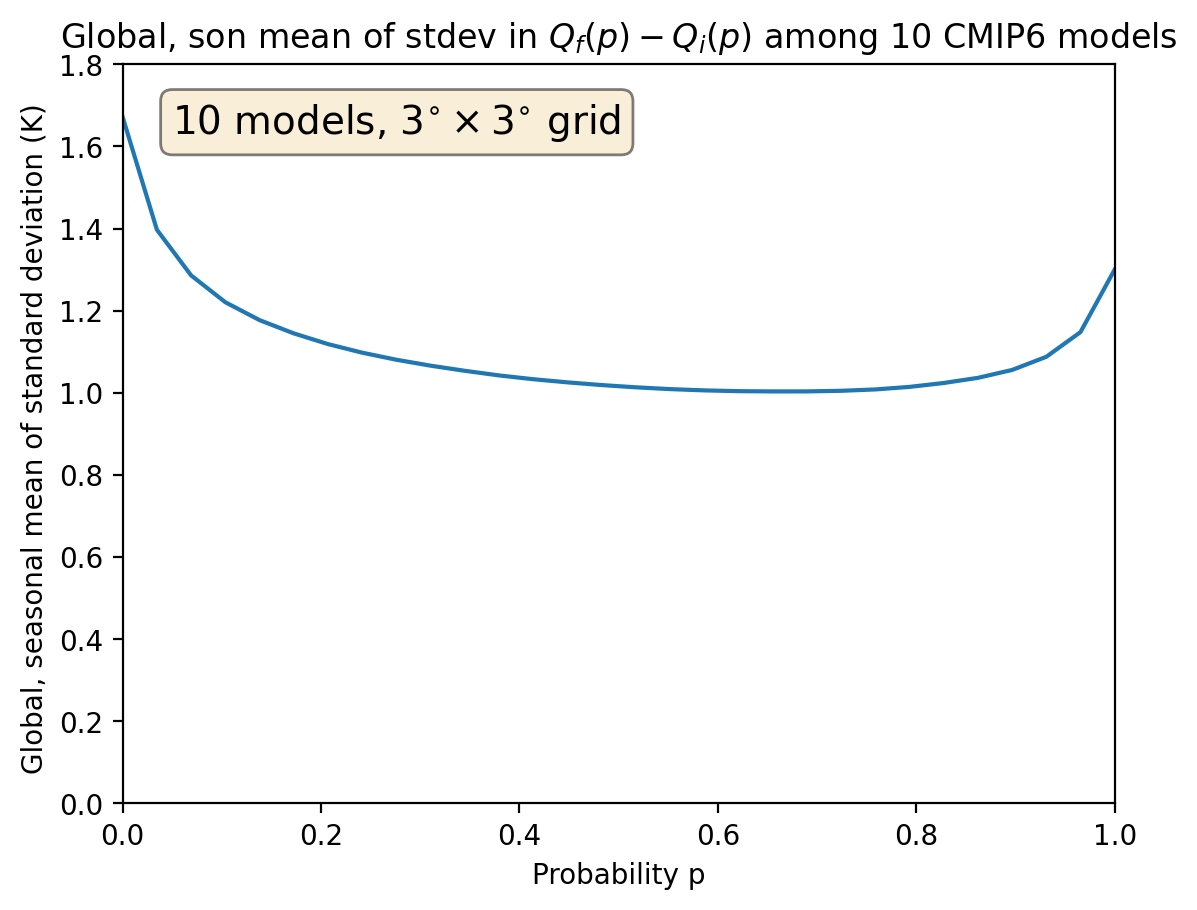

In [20]:
quant_ano_std_sgmean.plot()
plt.xlabel('Probability p')
plt.ylabel('Global, seasonal mean of standard deviation (K) ')
plt.title(r'Global, DJF mean of stdev in $Q_f(p) -Q_i(p)$ among 10 CMIP6 models')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, r'10 models, $3^{\circ} \times 3^{\circ}$ grid', transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.ylim(0,1.8)
plt.xlim(0,1.0)

In [21]:
################################################################

In [22]:
# #Select data for specific location to plot
# df_loc = final_ds.to_dataframe().reset_index()
# df_eoc = final_ds.sel(experiment_id='ssp370').sel(year= slice(2071,2100)).to_dataframe().reset_index()
# df_pi  = final_ds.sel(experiment_id='historical').sel(year= slice(1850,1879)).to_dataframe().reset_index()
# df_loc

In [23]:
# sns.relplot(data=df_loc,x="year", y="tasmax", hue='experiment_id',
#             kind="line", errorbar="sd", aspect=2);

In [24]:
# quantiles = np.linspace(0,1.0,30)
# quantiles

In [25]:
# df_eoc_quants                  = df_eoc.groupby('source_id')['tasmax'].quantile(quantiles).reset_index()
# df_eoc_quants.columns          = ['source_id','quantiles','tasmax']
# df_eoc_quants['experiment_id'] = 'ssp370'
# df_eoc_quants

In [26]:
# df_pi_quants                  = df_pi.groupby('source_id')['tasmax'].quantile(quantiles).reset_index()
# df_pi_quants.columns          = ['source_id','quantiles','tasmax']
# df_pi_quants['experiment_id'] = 'historical'
# df_pi_quants

In [27]:
# df_quants = pd.concat([df_eoc_quants, df_pi_quants],ignore_index=True)
# df_quants 

In [28]:
# g = sns.relplot(data=df_eoc_quants,x="quantiles", y="tasmax",hue='experiment_id',
#             kind="line", errorbar="sd", aspect=2);
# g.fig.suptitle('son 30, EOC tasmax at Chicago: 21 CMIP6 models')

In [29]:
# g = sns.relplot(data=df_quants,x="quantiles", y="tasmax",hue='experiment_id',
#             kind="line", errorbar="sd", aspect=2);
# g.fig.suptitle('son 30, tasmax at Chicago: 21 CMIP6 models')

In [30]:
############## Anomalies ###########################

In [31]:
# # Pivot the table based on experiment_id
# df_pivot = df_quants.pivot_table(index=['source_id', 'quantiles'], columns='experiment_id', values='tasmax')
# df_pivot

In [32]:
# # Calculate the difference
# df_pivot['tasmax_ano'] = df_pivot['ssp370'] - df_pivot['historical']
# df_pivot
# # Reset the index to turn multi-index back to columns
# df_quant_ano = df_pivot.reset_index()[['source_id', 'quantiles', 'tasmax_ano']]
# df_quant_ano

In [33]:
# g = sns.relplot(data=df_quant_ano,x="quantiles", y="tasmax_ano",
#             kind="line", errorbar="sd", aspect=2);
# g.fig.suptitle('son 30, tasmax anomaly at Chicago: 21 CMIP6 models')

In [34]:
# # Group by quantiles and compute the standard deviation for Tasmax
# df_quantano_std = df_quant_ano.groupby('quantiles')['tasmax_ano'].std().reset_index()

# # Rename the column for clarity
# df_quantano_std.rename(columns={'tasmax_ano': 'tasmax_sdev'}, inplace=True)
# df_quantano_std

In [35]:
# g = sns.relplot(data=df_quantano_std,x="quantiles", y="tasmax_sdev",
#             kind="line", errorbar="sd", aspect=2);
# g.fig.suptitle('son 30, tasmax std at Chicago: 21 CMIP6 models')